In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import time
from timeit import default_timer as timer
import torch
from torch.autograd import Variable

import numpy as np
import pickle
import pathlib

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda available


In [2]:
from core.SimpleConvNet import SimpleConvNet
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset
from util.evaluation_metrics import evaluate_net_metrics, evaluate_embedding_metrics

In [3]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [4]:
task_parameters = {}
task_parameters['net_type'] = 'graph_net'
task_parameters['reduction_method'] = 'preprocessed_tsne'
task_parameters['loss_function'] = 'pairwise_loss'
task_parameters['n_components'] = 2

net_parameters = {}
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['D'] = 784 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers
net_parameters['n_channels'] = 1 # for conv net
net_parameters['n_units_1'] = net_parameters['n_units_2'] = net_parameters['H'] # for conv net

In [5]:
if task_parameters['net_type'] == 'graph_net':
    net = GraphConvNet2(net_parameters)
elif task_parameters['net_type'] == 'conv_net':
    net = SimpleConvNet(net_parameters)
if torch.cuda.is_available():
    net.cuda()
print(net)

GraphConvNet2(
  (gnn_cells): ModuleList(
    (0): GraphConvNetCell(
      (Ui1): Linear(in_features=784, out_features=50, bias=False)
      (Uj1): Linear(in_features=784, out_features=50, bias=False)
      (Vi1): Linear(in_features=784, out_features=50, bias=False)
      (Vj1): Linear(in_features=784, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=784, out_features=50, bias=False)
    )
    (1): GraphConvNetCell(
      (Ui1): Linear(in_features=50, out_features=50, bias=False)
      (Uj1): Linear(in_features=50, out_features=50, bias=F

In [6]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 200   
opt_parameters['batch_iters'] = 10
opt_parameters['max_train_size'] = 20000   
opt_parameters['save_flag'] = True

if 2==1: # fast debugging
    opt_parameters['max_iters'] = 5 
    opt_parameters['batch_iters'] = 1
    opt_parameters['save_flag'] = False

opt_parameters['decay_rate'] = 1.25   

In [7]:
if opt_parameters['save_flag']: 
    checkpoint_interval = opt_parameters['max_iters']/5
    checkpoint_root = 'results/mnist_' + task_parameters['reduction_method'] + '2/'
    pathlib.Path(checkpoint_root).mkdir(exist_ok=True) # create the directory if it doesn't exist

## Prepare data

In [8]:
# Pre-processed train data
parent_dir = os.path.abspath('..')
filename = parent_dir + '/data/set_20000_mnist_tsne.pkl'
with open(filename, 'rb') as f:
    [inputs, labels, X_emb] = pickle.load(f)

In [9]:
all_train_data = []
num_train_samples = 0
while num_train_samples <= opt_parameters['max_train_size']:
    # Draw a random training batch of variable size
    num_samples = np.random.randint(200, 500)
    inputs_subset = inputs[num_train_samples:num_train_samples+num_samples]
    labels_subset = labels[num_train_samples:num_train_samples+num_samples]
    X_emb_subset = X_emb[num_train_samples:num_train_samples+num_samples]
    
    # Package into graph block
    G = DataEmbeddingGraph(inputs_subset, labels_subset, 'spectral')
    G.target = X_emb_subset
    
    all_train_data.append(G)
    num_train_samples += num_samples  

In [10]:
all_train_data = all_train_data[:len(all_train_data)-1]

In [11]:
dataset_sizes = [len(G.labels) for G in all_train_data]
print("Dataset sizes = {}".format(dataset_sizes))
print("Total number of samples = {}".format(sum(dataset_sizes)))

Dataset sizes = [288, 246, 453, 278, 278, 340, 213, 282, 393, 408, 459, 411, 373, 269, 347, 333, 484, 404, 452, 453, 232, 356, 445, 246, 360, 218, 299, 295, 256, 402, 312, 405, 405, 493, 354, 420, 329, 205, 403, 472, 297, 384, 251, 231, 370, 285, 466, 302, 202, 434, 490, 283, 250, 468, 233, 488, 363]
Total number of samples = 19868


In [12]:
# Test set
filename = parent_dir + '/data/set_100_usps_spectral_size_200_500.pkl'
with open(filename, 'rb') as f:
    [all_test_data] = pickle.load(f)

## Train net

In [13]:
# Optimization parameters
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
tab_results = []
    
for iteration in range(max_iters):
    
    for G in all_train_data:
        # Forward pass
        y_pred = net.forward(G)

        # Target embedding matrix
        y_true = G.target
        y_true = Variable(torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 

        # Compute overall loss 
        if task_parameters['loss_function'] == 'pairwise_loss':
            loss = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
        elif task_parameters['loss_function'] == 'composite_loss':
            loss1 = net.loss(y_pred, y_true)
            loss2 = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
            loss = 0.5*loss1 + 0.5*loss2
            
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        print('\niteration= %d, loss(%diter)= %.8f, lr= %.8f, time(%diter)= %.2f' %
              (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))
            
        # validate on test set
        #######################
        trustworthiness, one_nn, time_elapsed = evaluate_net_metrics(all_test_data, net)
        print("Trust = {:.4f}, 1-NN = {:.4f}, time to compute = {:.2f}s".format(trustworthiness, one_nn, time_elapsed))
        
        tab_results.append([iteration, average_loss, trustworthiness, one_nn, time.time()-t_start_total])
    
    if opt_parameters['save_flag'] and not (iteration+1)%checkpoint_interval:
        filename = checkpoint_root + task_parameters['net_type'] + str(int((iteration+1)/checkpoint_interval)) + '.pkl'
        save_checkpoint({
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, filename)

/home/leowyaoyang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 1996.25817871, lr= 0.00075000, time(10iter)= 11.98
Trust = 0.7725, 1-NN = 0.4244, time to compute = 0.22s

iteration= 10, loss(10iter)= 191.76527405, lr= 0.00075000, time(10iter)= 143.33
Trust = 0.7047, 1-NN = 0.3824, time to compute = 0.22s

iteration= 20, loss(10iter)= 50.74042511, lr= 0.00075000, time(10iter)= 143.76
Trust = 0.6953, 1-NN = 0.3786, time to compute = 0.22s

iteration= 30, loss(10iter)= 30.50015831, lr= 0.00075000, time(10iter)= 143.89
Trust = 0.7070, 1-NN = 0.3919, time to compute = 0.22s

iteration= 40, loss(10iter)= 23.37721062, lr= 0.00075000, time(10iter)= 144.48
Trust = 0.7123, 1-NN = 0.3931, time to compute = 0.23s

iteration= 50, loss(10iter)= 22.23198318, lr= 0.00075000, time(10iter)= 147.64
Trust = 0.7174, 1-NN = 0.4092, time to compute = 0.23s

iteration= 60, loss(10iter)= 13.43864250, lr= 0.00075000, time(10iter)= 147.76
Trust = 0.7192, 1-NN = 0.4091, time to compute = 0.23s

iteration= 70, loss(10iter)= 15.18221188, lr= 0.00060

In [14]:
# Save metadata 
if opt_parameters['save_flag']:
    metadata_filename = checkpoint_root + "experiment_metadata.txt"
    with open(metadata_filename, 'w') as f:
        f.write('-----------------------\n')
        f.write('\n'.join(["%s = %s" % (k,v) for k,v in task_parameters.items()]))
        
        f.write('\n-----------------------\n')
        f.write('\n'.join(["%s = %s" % (k,v) for k,v in net_parameters.items()]))
        
        f.write('\n-----------------------\n')
        f.write('\n'.join(["%s = %s" % (k,v) for k,v in opt_parameters.items()]))

Text(0.5,0,'Iteration')

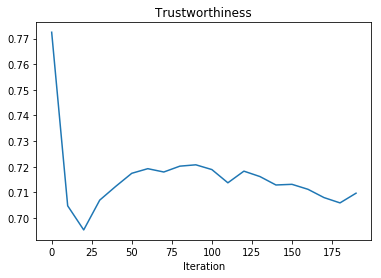

In [23]:
iterations = [res[0] for res in tab_results]
trust_score = [res[2] for res in tab_results]
nn_score = [res[3] for res in tab_results]
plt.plot(iterations, trust_score)
plt.title('Trustworthiness')
plt.xlabel('Iteration')

Text(0.5,0,'Iteration')

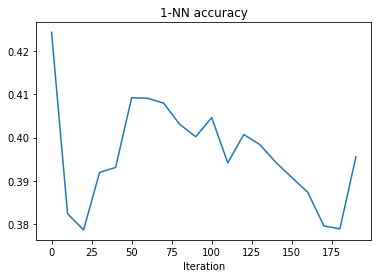

In [24]:
plt.plot(iterations, nn_score)
plt.title('1-NN accuracy')
plt.xlabel('Iteration')

## On test data

In [15]:
# inputs, labels = draw_random_subset(test_data, num_samples=500)
# G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
# net_time_start = timer()
# if torch.cuda.is_available():   
#     y_pred = net.forward(G).cpu().detach().numpy()
# else:    
#     y_pred = net.forward(G).detach().numpy()
# net_time_end = timer()

# f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
# reduction_title = task_parameters['reduction_method'] + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
# cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
# plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), reduction_title)
# plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), cnn_title)